In [1]:
import pandas as pd
import tarfile
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

plt.style.use('grayscale')

In [2]:
class Module:
    def __init__(self):
        self._train = True

    def forward(self, input):
        raise NotImplementedError

    def backward(self, input, grad_output):
        raise NotImplementedError
          

    def parameters(self):
        """
        Returns list of its parameters
        """
        return []

    def grad_parameters(self):
        """
        Returns list of tensors gradients of its parameters
        """
        return []

    def train(self):
        self._train = True

    def eval(self):
        self._train = False

In [3]:
class Criterion:
    def forward(self, input, target):
        raise NotImplementedError

    def backward(self, input, target):
        raise NotImplementedError

In [4]:
class Linear(Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.W = np.random.randn(dim_in, dim_out)
        self.b = np.random.randn(1, dim_out)

        # Additional parameters for resilient backpropagation
        self.prev_grad_W = np.zeros_like(self.W)
        self.prev_grad_b = np.zeros_like(self.b)
        self.update_W = np.ones_like(self.W)
        self.update_b = np.ones_like(self.b)

    def forward(self, input):
        self.output = np.dot(input, self.W) + self.b
        return self.output

    def backward(self, input, grad_output):
        self.grad_b = np.mean(grad_output, axis=0)
        self.grad_W = np.dot(input.T, grad_output)

        self.grad_W /= input.shape[0]

        grad_input = np.dot(grad_output, self.W.T)

        return grad_input

    

    def parameters(self):
        return [self.W, self.b]

    def grad_parameters(self):
        return [self.grad_W, self.grad_b]


In [29]:
def softmax(xs):
    xs = np.subtract(xs, xs.max(axis=1, keepdims=True))
    xs = np.exp(xs) / np.sum(np.exp(xs), axis=1, keepdims=True)
    return xs


class CrossEntropy(Criterion):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        eps = 1e-9
        predictions = np.clip(input, eps, 1. - eps)
        N = predictions.shape[0]
        ce = -np.sum(target * np.log(predictions))
        return ce / N


    def backward(self, input, target):
        eps = 1e-9
        input_clamp = np.clip(input, eps, 1 - eps)
        return softmax(input_clamp) - target

In [6]:
class Sequential(Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = layers

    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)

        self.output = input
        return self.output

    def backward(self, input, grad_output):
        for i in range(len(self.layers) - 1, 0, -1):
            grad_output = self.layers[i].backward(self.layers[i-1].output, grad_output)

        grad_output = self.layers[0].backward(input, grad_output)

        return grad_output

    
    
    def parameters(self):
        res = []
        for l in self.layers:
            res += l.parameters()
        return res

    def grad_parameters(self):
        res = []
        for l in self.layers:
            res += l.grad_parameters()
        return res

    def train(self):
        for layer in self.layers:
            layer.train()

    def eval(self):
        for layer in self.layers:
            layer.eval()

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


class Sigmoid(Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        self.output = sigmoid(input)
        return self.output

    def backward(self, input, grad_output):
        grad_input = sigmoid(input) * (1 - sigmoid(input)) * grad_output
        return grad_input

In [8]:
def relu(x):
    return np.maximum(0, x)

class ReLU(Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        self.output = relu(input)
        return self.output

    def backward(self, input, grad_output):
        grad_input = (input > 0) * grad_output
        return grad_input

In [9]:
def tanh(x):
    return np.tanh(x)

class Tanh(Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        self.output = tanh(input)
        return self.output

    def backward(self, input, grad_output):
        grad_input = (1 - np.square(tanh(input))) * grad_output
        return grad_input

In [10]:
class SoftMax(Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))
        self.output = np.exp(self.output) / np.sum(np.exp(self.output), axis=1, keepdims=True)
        return self.output

    def backward(self, input, grad_output):
        return grad_output

In [11]:
def DataLoader(X, Y, batch_size=32):
    n = X.shape[0]
    indices = np.arange(n)
    np.random.shuffle(indices)
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        batch_idx = indices[start:end]
        yield X[batch_idx], Y[batch_idx]

In [65]:
def accuracy_score(y_true, y_pred):
    a = np.argmax(y_true, axis=1)
    b = np.argmax(y_pred, axis=1)
    return np.count_nonzero(a == b) / y_true.shape[0]

def precision_score(y_true, y_pred):
    a = np.argmax(y_true, axis=1)
    b = np.argmax(y_pred, axis=1)
    true_positives = np.count_nonzero((a == 1) & (b == 1))
    false_positives = np.count_nonzero((a == 0) & (b == 1))
    precision = true_positives / (true_positives + false_positives)
    return precision

def recall_score(y_true, y_pred):
    a = np.argmax(y_true, axis=1)
    b = np.argmax(y_pred, axis=1)
    true_positives = np.count_nonzero((a == 1) & (b == 1))
    false_negatives = np.count_nonzero((a == 1) & (b == 0))
    recall = true_positives / (true_positives + false_negatives)
    return recall

def f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

def confusion_matrix(y_true, y_pred):
    a = np.argmax(y_true, axis=1)
    b = np.argmax(y_pred, axis=1)
    true_positive = np.count_nonzero((a == 1) & (b == 1))
    false_positive = np.count_nonzero((a == 0) & (b == 1))
    true_negative = np.count_nonzero((a == 0) & (b == 0))
    false_negative = np.count_nonzero((a == 1) & (b == 0))
    return np.array([[true_positive, false_positive],
                     [false_negative, true_negative]])

In [13]:
class Adam:
    def __init__(self, model):
        self.prev_m = None
        self.prev_v = None
        self.model = model
        self.t = 1

    def step(self, lr, beta1, beta2):
        prev_m_tmp = []
        prev_v_tmp = []
        eps = 1e-7

        for i, (weights, gradient) in enumerate(zip(self.model.parameters(), self.model.grad_parameters())):
            if self.prev_m and self.prev_v:
                m = beta1 * self.prev_m[i] + (1 - beta1) * gradient
                v = beta2 * self.prev_v[i] + (1 - beta2) * gradient ** 2
                m_hat = m / (1 - beta1 ** self.t)
                v_hat = v / (1 - beta2 ** self.t)
            else:
                m = beta1 * 0 + (1 - beta1) * gradient
                v = beta2 * 0 + (1 - beta2) * gradient ** 2
                m_hat = m / (1 - beta1 ** self.t)
                v_hat = v / (1 - beta2 ** self.t)

            weights -= lr * m_hat / (np.sqrt(v_hat) + eps)

            prev_m_tmp.append(m)
            prev_v_tmp.append(v)

        self.prev_m = prev_m_tmp
        self.prev_v = prev_v_tmp

        self.t += 1

In [14]:
def loadECGData():
  return pd.read_csv("/kaggle/input/myecg-dataset/mitbih_train.csv", header=None), pd.read_csv("/kaggle/input/myecg-dataset/mitbih_test.csv", header=None)

In [15]:
ECG_train_data, ECG_test_data = loadECGData()

In [16]:
from sklearn.utils import resample
df_1=ECG_train_data[ECG_train_data[187]==1]
df_2=ECG_train_data[ECG_train_data[187]==2]
df_3=ECG_train_data[ECG_train_data[187]==3]
df_4=ECG_train_data[ECG_train_data[187]==4]
df_0=(ECG_train_data[ECG_train_data[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

ECG_train_data=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [17]:
# convert the trainig set to numpy matrix
ECG_train_data = np.array(ECG_train_data)
# get the label from the matrix and convert it(the label) into integers
ECG_train_data_label = ECG_train_data[:,-1]
ECG_train_data_label = ECG_train_data_label.astype('int64')
# drop the label from the training set
ECG_train_data = ECG_train_data[:,:187]

<BarContainer object of 5 artists>

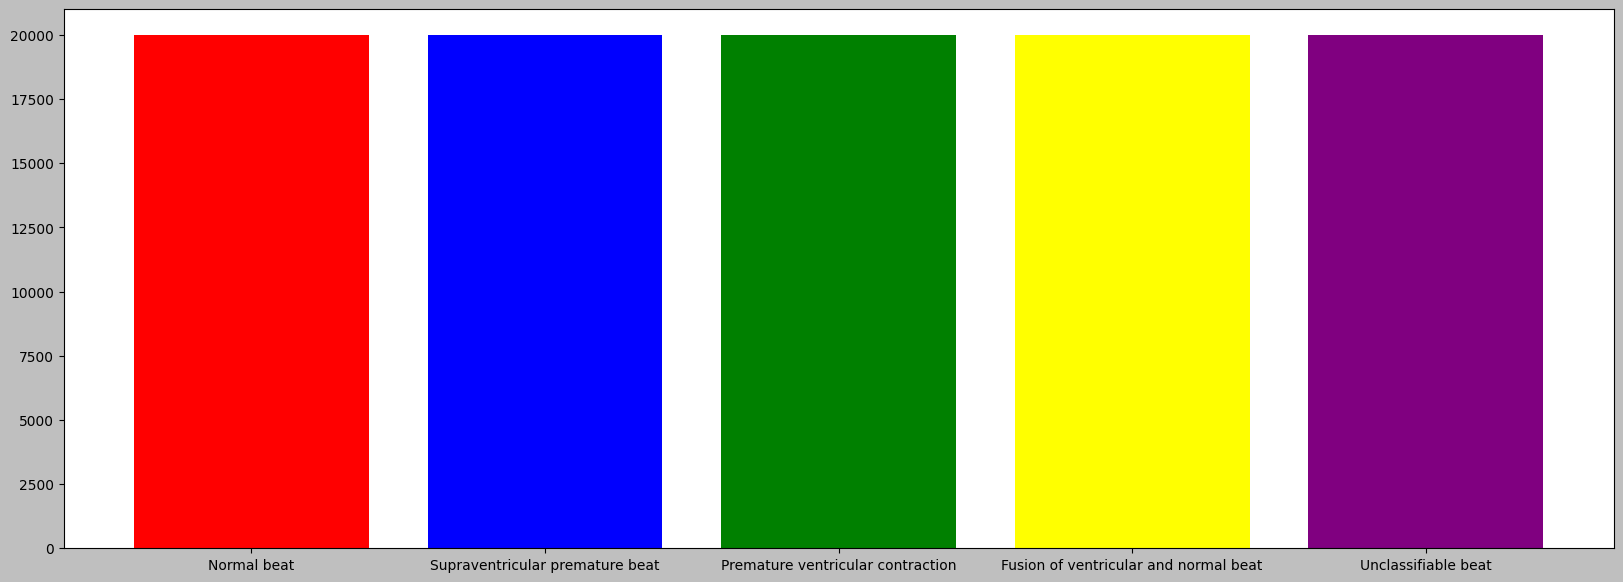

In [18]:
labels = ['Normal beat', 'Supraventricular premature beat', 'Premature ventricular contraction', 'Fusion of ventricular and normal beat', 'Unclassifiable beat']
# count the number of occurrences of each label and create a 1-dimensional array with each label and its number of occurrences
# the pd.Series makes a 1-dimensional array with index(name of the label here) and value (number of occurrence)
# the np.bincount counts the number of occurence for each value in the given 1-dimensional array
# the np.ravel convert the np matrix (87553, 1) into 1-dimensional array (which is required for the np.bincount function)
each_label_occurrence_train = pd.Series(np.bincount(np.ravel(ECG_train_data_label)), index=labels)
# print the occurrence of each label with some colors ^_^
plt.figure(figsize=(20,7))
colors = ['red', 'blue', 'green', 'yellow', 'purple']
plt.bar(each_label_occurrence_train.index, each_label_occurrence_train.values, color=colors)

In [19]:
# convert the testing set to numpy matrix
ECG_test_data = np.array(ECG_test_data)
# get the label from the matrix and convert it(the label) into integers
ECG_test_data_label = ECG_test_data[:,-1]
ECG_test_data_label = ECG_test_data_label.astype('int64')
# drop the label from the testing set
ECG_test_data = ECG_test_data[:,:187]

<BarContainer object of 5 artists>

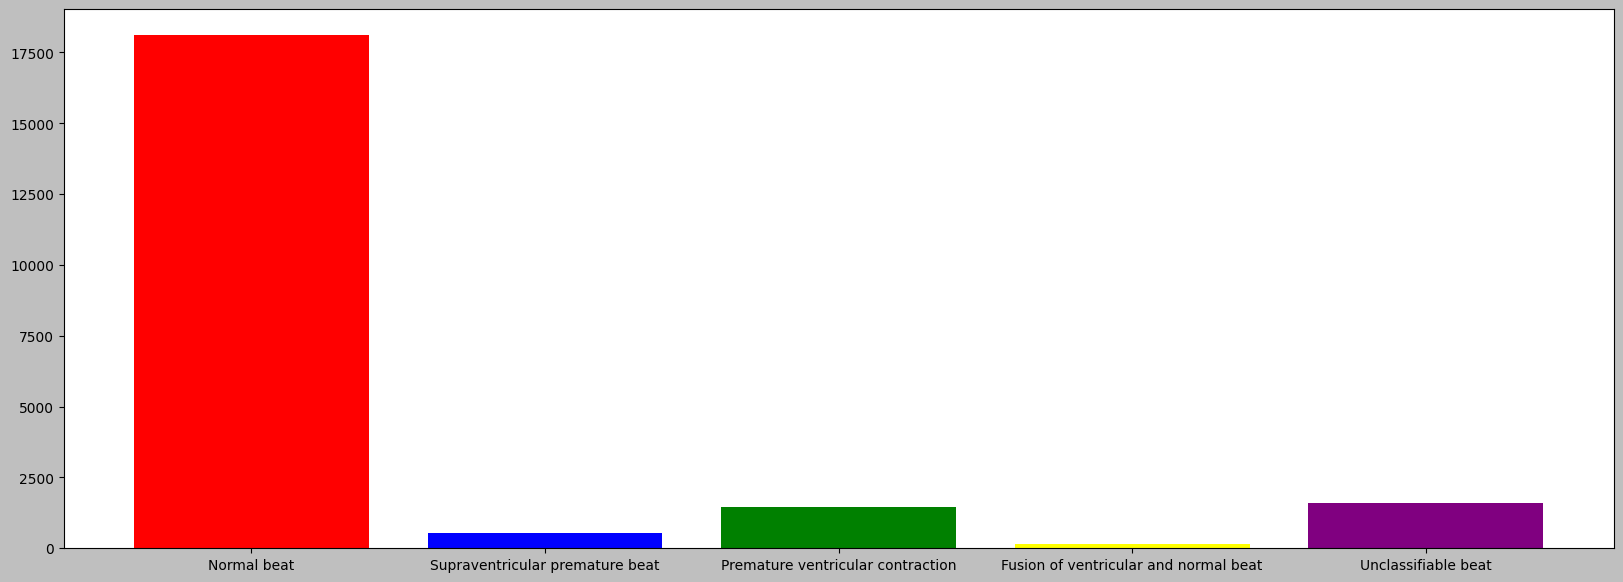

In [20]:
labels = ['Normal beat', 'Supraventricular premature beat', 'Premature ventricular contraction', 'Fusion of ventricular and normal beat', 'Unclassifiable beat']
# count the number of occurrences of each label and create a 1-dimensional array with each label and its number of occurrences
each_label_occurrence_test = pd.Series(np.bincount(np.ravel(ECG_test_data_label)), index=labels)
# print the occurrence of each label with some colors ^_^
plt.figure(figsize=(20,7))
colors = ['red', 'blue', 'green', 'yellow', 'purple']
plt.bar(each_label_occurrence_test.index, each_label_occurrence_test.values, color=colors)

In [21]:
print(ECG_train_data.shape)
print(ECG_train_data_label.shape)
print(ECG_test_data.shape)
print(ECG_test_data_label.shape)

(100000, 187)
(100000,)
(21892, 187)
(21892,)


In [22]:
# make a standardized copy of the data set passed on the train dataset mean, max and min
scaler = StandardScaler().fit(ECG_train_data)
ECG_train_data_standardized = scaler.transform(ECG_train_data)
ECG_test_data_standardized = scaler.transform(ECG_test_data)

In [23]:
# apply one hot encoding for the labels of all the three datasets and then conver them into np.array using the toarray() function
category_encoder = OneHotEncoder(sparse=False)
ECG_train_data_1Hot_label = category_encoder.fit_transform(ECG_train_data_label.reshape(ECG_train_data_label.shape[0], 1))
#ECG_train_data_1Hot_label.toarray()
#ECG_val_data_1Hot_label.toarray()
ECG_test_data_1Hot_label = category_encoder.fit_transform(ECG_test_data_label.reshape(ECG_test_data_label.shape[0], 1))
#ECG_test_data_1Hot_label.toarray()

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [24]:
X_train= ECG_train_data_standardized
X_test= ECG_test_data_standardized
y_train= ECG_train_data_1Hot_label
y_test = ECG_test_data_1Hot_label

Epoch: 5/35
Train Loss: 2.7194289655293753 Train Accuracy: 0.289 Train Recall: 0.7654553175999514 Train Precision: 0.5607804791324059
Test Loss: 2.778495985584517 Test Accuracy: 0.1895212863146355 Test Recall: 0.7903225806451613 Test Precision: 0.03674737518748661

Epoch: 10/35
Train Loss: 1.9252458753824773 Train Accuracy: 0.3958 Train Recall: 0.7019859674158639 Train Precision: 0.6379552577542419
Test Loss: 2.315742479849776 Test Accuracy: 0.27297642974602593 Test Recall: 0.7460674157303371 Test Precision: 0.050920245398773004

Epoch: 15/35
Train Loss: 1.582442727563281 Train Accuracy: 0.49764 Train Recall: 0.6997296979668586 Train Precision: 0.6844858308903834
Test Loss: 2.124373196323606 Test Accuracy: 0.3297551617029052 Test Recall: 0.7208791208791209 Test Precision: 0.06125116713352007

Epoch: 20/35
Train Loss: 1.438182157630052 Train Accuracy: 0.55369 Train Recall: 0.6938367442954599 Train Precision: 0.7076535508637236
Test Loss: 1.976286361838452 Test Accuracy: 0.38205737255618

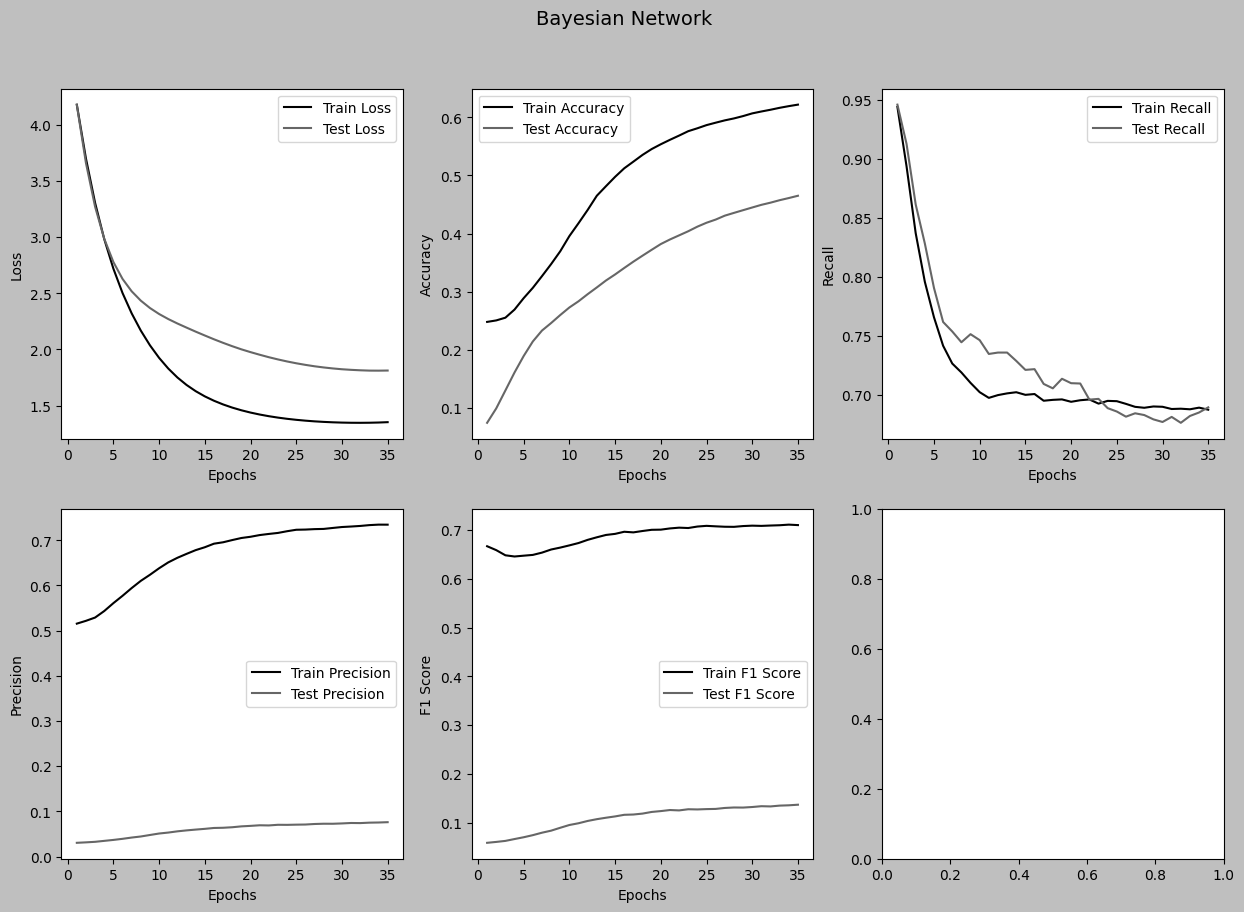

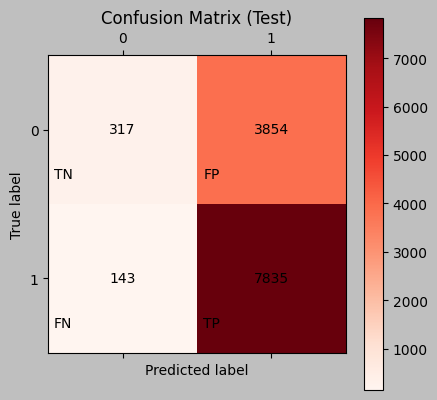

In [83]:
BPmodel = Sequential(
    Linear(187, 200),
    Sigmoid(),

    Linear(200, 40),
    Sigmoid(),

    Linear(40, 5),
    SoftMax(),

)


epochs = 35
eval_every = 1
batch_size = 1024
criterion = CrossEntropy()


train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
train_recalls = []
test_recalls = []
train_precisions = []
test_precisions = []
train_f1_scores = []
test_f1_scores = []

learning_rate = 0.003

for epoch in range(epochs):
    for x, y in DataLoader(X_train, y_train, batch_size=batch_size):
        BPmodel.train()

        y_pred = BPmodel.forward(x)
        grad = criterion.backward(y_pred, y)
        BPmodel.backward(x, grad)
        
        
        # Update weights manually
        for layer in BPmodel.layers:
            if hasattr(layer, 'parameters') and hasattr(layer, 'grad_parameters'):
                params = layer.parameters()
                grads = layer.grad_parameters()
                for param, grad in zip(params, grads):
                    param -= learning_rate * grad 

  
        
    if (epoch + 1) % eval_every == 0:
        BPmodel.eval()
        
        y_train_pred = BPmodel.forward(X_train)
        y_test_pred = BPmodel.forward(X_test)
        
        loss_train = criterion.forward(y_train_pred, y_train)
        loss_test = criterion.forward(y_test_pred, y_test)
        
        acc_train = accuracy_score(y_train, y_train_pred)
        acc_test = accuracy_score(y_test, y_test_pred)
        
        recall_train = recall_score(y_train, y_train_pred)
        recall_test = recall_score(y_test, y_test_pred)
        
        precision_train = precision_score(y_train, y_train_pred)
        precision_test = precision_score(y_test, y_test_pred)
        
        f1_score_train = f1_score(y_train, y_train_pred)
        f1_score_test = f1_score(y_test, y_test_pred)
        confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
        confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
        
        # Append metrics to lists
        train_losses.append(loss_train)
        test_losses.append(loss_test)
        train_accuracies.append(acc_train)
        test_accuracies.append(acc_test)
        train_recalls.append(recall_train)
        test_recalls.append(recall_test)
        train_precisions.append(precision_train)
        test_precisions.append(precision_test)
        train_f1_scores.append(f1_score_train)
        test_f1_scores.append(f1_score_test)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch: {epoch + 1}/{epochs}')
            print(f'Train Loss: {loss_train} Train Accuracy: {acc_train} Train Recall: {recall_train} Train Precision: {precision_train}')
            print(f'Test Loss: {loss_test} Test Accuracy: {acc_test} Test Recall: {recall_test} Test Precision: {precision_test}\n')

# Calculate confusion matrix




# Plotting
plt.figure(figsize=(15, 10))
plt.figtext(0.5, 0.95, 'Bayesian Network', ha='center', va='center', fontsize=14)

plt.subplot(2, 3, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(range(1, epochs+1), train_recalls, label='Train Recall')
plt.plot(range(1, epochs+1), test_recalls, label='Test Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(range(1, epochs+1), train_precisions, label='Train Precision')
plt.plot(range(1, epochs+1), test_precisions, label='Test Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(range(1, epochs+1), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, epochs+1), test_f1_scores, label='Test F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()


plt.subplot(2, 3, 6)
plt.matshow(confusion_matrix_test, cmap='Reds')
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.colorbar()

# Annotate the confusion matrix with counts or percentages
for i in range(confusion_matrix_test.shape[0]):
    for j in range(confusion_matrix_test.shape[1]):
        plt.text(j, i, str(confusion_matrix_test[i, j]), ha='center', va='center', color='black')
        
# Annotate the confusion matrix with TP, TN, FP, FN labels
for i in range(confusion_matrix_test.shape[0]):
    for j in range(confusion_matrix_test.shape[1]):
        if i == 0 and j == 0:  # TN
            plt.text(j - 0.4, i + 0.3, 'TN', ha='center', va='center', color='black')
        elif i == 1 and j == 1:  # TP
            plt.text(j - 0.4, i + 0.3, 'TP', ha='center', va='center', color='black')
        elif i == 0:  # FP
            plt.text(j - 0.4, i + 0.3, 'FP', ha='center', va='center', color='black')
        else:  # FN
            plt.text(j - 0.4, i + 0.3, 'FN', ha='center', va='center', color='black')


plt.show()

/tmp/ipykernel_33/3492120931.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch: 5/35
Train Loss: 2.5261058076926464 Train Accuracy: 0.87647 Train Recall: 0.8998794359700163 Train Precision: 0.880629937416641
Test Loss: 4.76363919288036 Test Accuracy: 0.7665813995980266 Test Recall: 0.8607843137254902 Test Precision: 0.16584812995844353

Epoch: 10/35
Train Loss: 2.090475433589384 Train Accuracy: 0.89849 Train Recall: 0.9230889560955261 Train Precision: 0.8969448244414044
Test Loss: 4.323280131207195 Test Accuracy: 0.789923259638224 Test Recall: 0.8718929254302104 Test Precision: 0.18424242424242424

Epoch: 15/35
Train Loss: 1.7787673122868324 Train Accuracy: 0.91335 Train Recall: 0.872788115398266 Train Precision: 0.9481163251817581
Test Loss: 2.287669442248801 Test Accuracy: 0.8887721542115842 Test Recall: 0.8014842300556586 Test Precision: 0.3130434782608696

Epoch: 20/35
Train Loss: 1.4995221465598518 Train Accuracy: 0.9272 Train Recall: 0.9155037964293044 Train Precision: 0.9410430839002267
Test Loss: 2.6305175468368622 Test Accuracy: 0.8724191485474145 

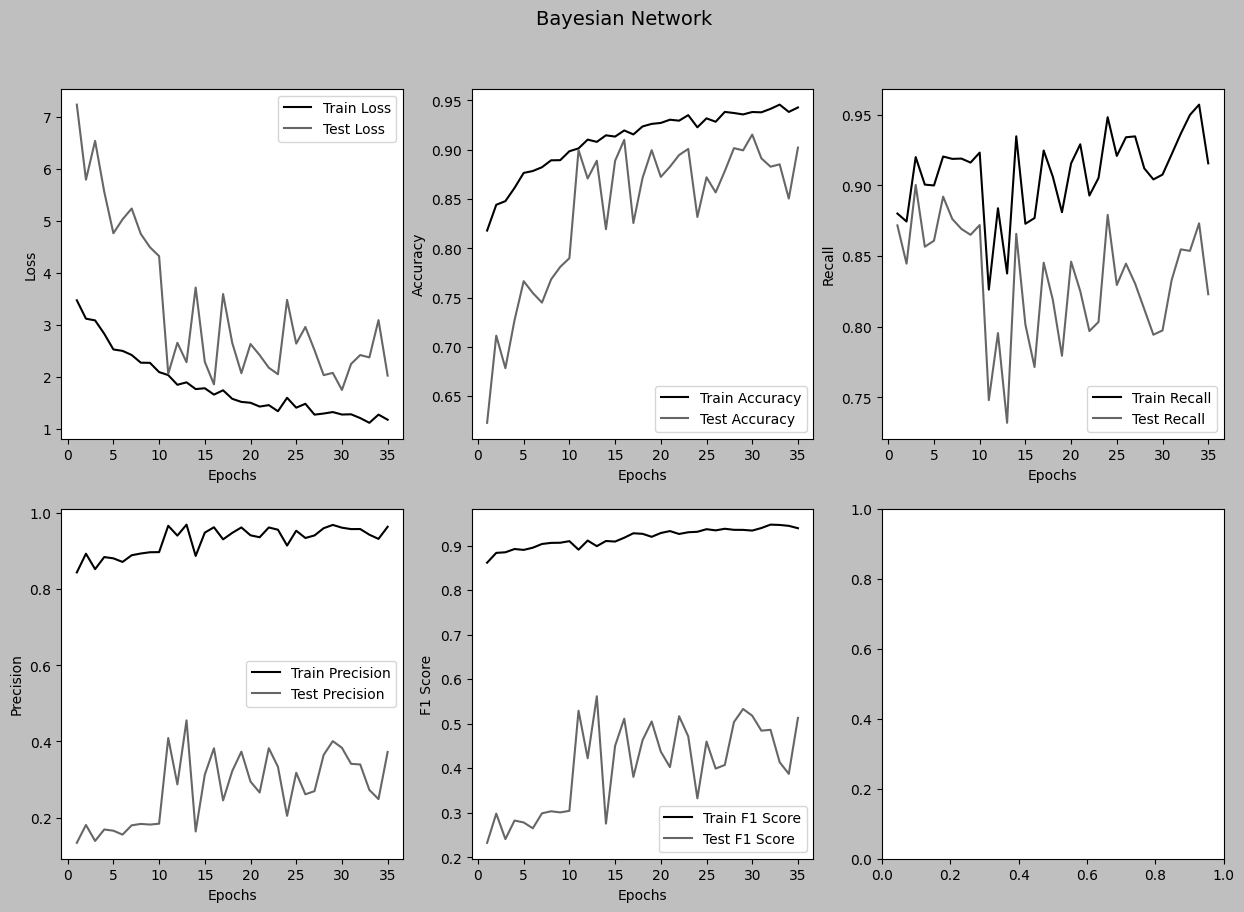

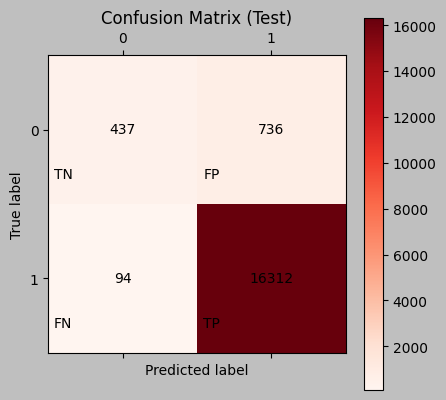

In [84]:
RPmodel = Sequential(
    Linear(187, 200),
    Sigmoid(),

    Linear(200, 40),
    Sigmoid(),

    Linear(40, 5),
    SoftMax(),

)

epochs = 35
eval_every = 1
batch_size = 1024
criterion = CrossEntropy()

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
train_recalls = []
test_recalls = []
train_precisions = []
test_precisions = []
train_f1_scores = []
test_f1_scores = []

for epoch in range(epochs):
    for x, y in DataLoader(X_train, y_train, batch_size=batch_size):
        RPmodel.train()

        y_pred = RPmodel.forward(x)
        grad = criterion.backward(y_pred, y)
        RPmodel.backward(x, grad)
        
    # Update weights and biases using resilient backpropagation
        for layer in RPmodel.layers:
            if hasattr(layer, 'parameters') and hasattr(layer, 'grad_parameters'):
                params = layer.parameters()
                grads = layer.grad_parameters()
                prev_gradients = getattr(layer, 'prev_gradients', None)
                if prev_gradients is None:
                    prev_gradients = [0.1 * np.ones_like(param) for param in params]
                    setattr(layer, 'prev_gradients', prev_gradients)
                for i, (param, grad, prev_grad) in enumerate(zip(params, grads, prev_gradients)):
                    sign = np.sign(grad * prev_grad)
                    for j in range(len(sign)):
                        if np.all(sign > 0):
                            prev_gradients[i][j] = min(prev_gradients[i][j] * 1.2, 50.0)
                            param[j] -= prev_gradients[i][j] * np.sign(grad[j])
                        elif np.all(sign < 0):
                            prev_gradients[i][j] = max(prev_gradients[i][j] * 0.5, 1e-6)
                            param[j] -= prev_gradients[i][j] * np.sign(grad[j])
                            grad[j] = 0
                        else:
                            param[j] -= prev_gradients[i][j] * np.sign(grad[j])


        
        
    if (epoch + 1) % eval_every == 0:
        RPmodel.eval()
        
        y_train_pred = RPmodel.forward(X_train)
        y_test_pred = RPmodel.forward(X_test)
        
        loss_train = criterion.forward(y_train_pred, y_train)
        loss_test = criterion.forward(y_test_pred, y_test)
        
        acc_train = accuracy_score(y_train, y_train_pred)
        acc_test = accuracy_score(y_test, y_test_pred)
        
        recall_train = recall_score(y_train, y_train_pred)
        recall_test = recall_score(y_test, y_test_pred)
        
        precision_train = precision_score(y_train, y_train_pred)
        precision_test = precision_score(y_test, y_test_pred)
        
        f1_score_train = f1_score(y_train, y_train_pred)
        f1_score_test = f1_score(y_test, y_test_pred)
        confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
        confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
        
        # Append metrics to lists
        train_losses.append(loss_train)
        test_losses.append(loss_test)
        train_accuracies.append(acc_train)
        test_accuracies.append(acc_test)
        train_recalls.append(recall_train)
        test_recalls.append(recall_test)
        train_precisions.append(precision_train)
        test_precisions.append(precision_test)
        train_f1_scores.append(f1_score_train)
        test_f1_scores.append(f1_score_test)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch: {epoch + 1}/{epochs}')
            print(f'Train Loss: {loss_train} Train Accuracy: {acc_train} Train Recall: {recall_train} Train Precision: {precision_train}')
            print(f'Test Loss: {loss_test} Test Accuracy: {acc_test} Test Recall: {recall_test} Test Precision: {precision_test}\n')

# Calculate confusion matrix




# Plotting
plt.figure(figsize=(15, 10))
plt.figtext(0.5, 0.95, 'Bayesian Network', ha='center', va='center', fontsize=14)

plt.subplot(2, 3, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(range(1, epochs+1), train_recalls, label='Train Recall')
plt.plot(range(1, epochs+1), test_recalls, label='Test Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(range(1, epochs+1), train_precisions, label='Train Precision')
plt.plot(range(1, epochs+1), test_precisions, label='Test Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(range(1, epochs+1), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, epochs+1), test_f1_scores, label='Test F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()


plt.subplot(2, 3, 6)
plt.matshow(confusion_matrix_test, cmap='Reds')
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.colorbar()

# Annotate the confusion matrix with counts or percentages
for i in range(confusion_matrix_test.shape[0]):
    for j in range(confusion_matrix_test.shape[1]):
        plt.text(j, i, str(confusion_matrix_test[i, j]), ha='center', va='center', color='black')
        
# Annotate the confusion matrix with TP, TN, FP, FN labels
for i in range(confusion_matrix_test.shape[0]):
    for j in range(confusion_matrix_test.shape[1]):
        if i == 0 and j == 0:  # TN
            plt.text(j - 0.4, i + 0.3, 'TN', ha='center', va='center', color='black')
        elif i == 1 and j == 1:  # TP
            plt.text(j - 0.4, i + 0.3, 'TP', ha='center', va='center', color='black')
        elif i == 0:  # FP
            plt.text(j - 0.4, i + 0.3, 'FP', ha='center', va='center', color='black')
        else:  # FN
            plt.text(j - 0.4, i + 0.3, 'FN', ha='center', va='center', color='black')


plt.show()

Epoch: 5/35
Train Loss: 1.3618011852058494 Train Accuracy: 0.86788 Train Recall: 0.8694611388407864 Train Precision: 0.8624766331531349
Test Loss: 1.9872442084927764 Test Accuracy: 0.7645715329800841 Test Recall: 0.8185255198487713 Test Precision: 0.14783202458176853

Epoch: 10/35
Train Loss: 0.949592160033108 Train Accuracy: 0.92029 Train Recall: 0.9219750844807586 Train Precision: 0.8980594448538443
Test Loss: 1.7271169479780386 Test Accuracy: 0.8347798282477618 Test Recall: 0.8161350844277674 Test Precision: 0.17561566410981025

Epoch: 15/35
Train Loss: 0.7069660069612796 Train Accuracy: 0.94433 Train Recall: 0.9278676988036594 Train Precision: 0.928194297782471
Test Loss: 1.508492967960428 Test Accuracy: 0.8797277544308423 Test Recall: 0.8164794007490637 Test Precision: 0.23415682062298604

Epoch: 20/35
Train Loss: 0.5754196764419247 Train Accuracy: 0.95528 Train Recall: 0.925242085193919 Train Precision: 0.9471494607087827
Test Loss: 1.2788266643047466 Test Accuracy: 0.90526219623

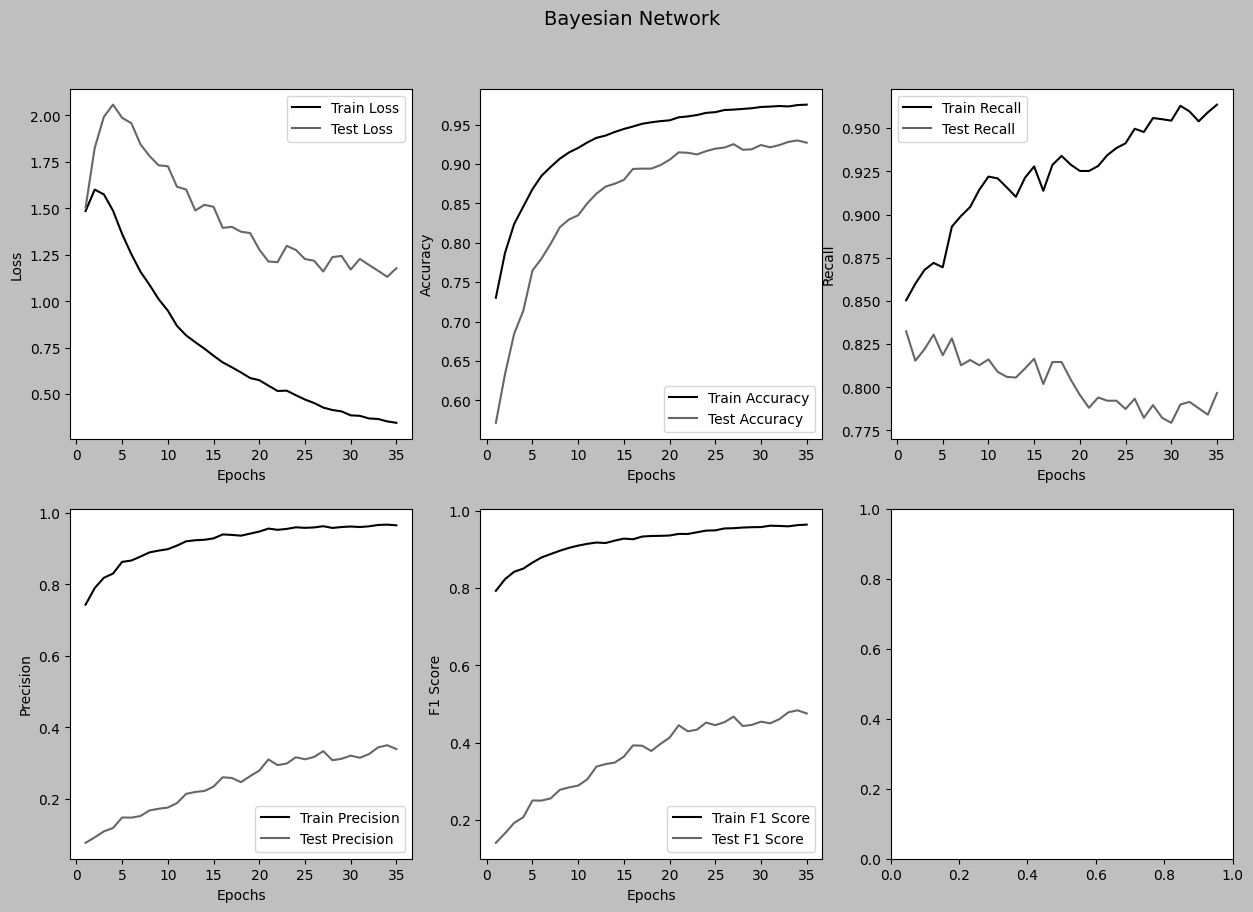

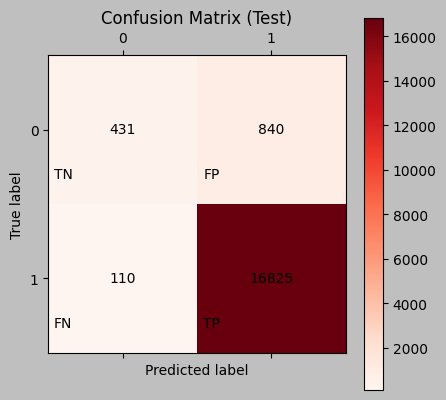

In [85]:
Adam_model = Sequential(
    Linear(187, 200),
    Sigmoid(),

    Linear(200, 40),
    Sigmoid(),

    Linear(40, 5),
    SoftMax(),
)


epochs = 35
eval_every = 1
batch_size = 1024
criterion = CrossEntropy()

optimizer = Adam(Adam_model)

# Define lists to store metrics during training and testing
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
train_recalls = []
test_recalls = []
train_precisions = []
test_precisions = []
train_f1_scores = []
test_f1_scores = []

for epoch in range(epochs):
    for x, y in DataLoader(X_train, y_train, batch_size=batch_size):
        Adam_model.train()

        y_pred = Adam_model.forward(x)
        grad = criterion.backward(y_pred, y)
        Adam_model.backward(x, grad)

        optimizer.step(lr=0.003, beta1=0.9, beta2=0.999)
        
    if (epoch + 1) % eval_every == 0:
        Adam_model.eval()

        y_train_pred = Adam_model.forward(X_train)
        y_test_pred = Adam_model.forward(X_test)
        
        loss_train = criterion.forward(y_train_pred, y_train)
        loss_test = criterion.forward(y_test_pred, y_test)
        
        acc_train = accuracy_score(y_train, y_train_pred)
        acc_test = accuracy_score(y_test, y_test_pred)
        
        recall_train = recall_score(y_train, y_train_pred)
        recall_test = recall_score(y_test, y_test_pred)
        
        precision_train = precision_score(y_train, y_train_pred)
        precision_test = precision_score(y_test, y_test_pred)
        
        f1_score_train = f1_score(y_train, y_train_pred)
        f1_score_test = f1_score(y_test, y_test_pred)
        confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
        confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
        
        # Append metrics to lists
        train_losses.append(loss_train)
        test_losses.append(loss_test)
        train_accuracies.append(acc_train)
        test_accuracies.append(acc_test)
        train_recalls.append(recall_train)
        test_recalls.append(recall_test)
        train_precisions.append(precision_train)
        test_precisions.append(precision_test)
        train_f1_scores.append(f1_score_train)
        test_f1_scores.append(f1_score_test)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch: {epoch + 1}/{epochs}')
            print(f'Train Loss: {loss_train} Train Accuracy: {acc_train} Train Recall: {recall_train} Train Precision: {precision_train}')
            print(f'Test Loss: {loss_test} Test Accuracy: {acc_test} Test Recall: {recall_test} Test Precision: {precision_test}\n')

# Calculate confusion matrix




# Plotting
plt.figure(figsize=(15, 10))
plt.figtext(0.5, 0.95, 'Bayesian Network', ha='center', va='center', fontsize=14)

plt.subplot(2, 3, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(range(1, epochs+1), train_recalls, label='Train Recall')
plt.plot(range(1, epochs+1), test_recalls, label='Test Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(range(1, epochs+1), train_precisions, label='Train Precision')
plt.plot(range(1, epochs+1), test_precisions, label='Test Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(range(1, epochs+1), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, epochs+1), test_f1_scores, label='Test F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()


plt.subplot(2, 3, 6)
plt.matshow(confusion_matrix_test, cmap='Reds')
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.colorbar()

# Annotate the confusion matrix with counts or percentages
for i in range(confusion_matrix_test.shape[0]):
    for j in range(confusion_matrix_test.shape[1]):
        plt.text(j, i, str(confusion_matrix_test[i, j]), ha='center', va='center', color='black')
        
# Annotate the confusion matrix with TP, TN, FP, FN labels
for i in range(confusion_matrix_test.shape[0]):
    for j in range(confusion_matrix_test.shape[1]):
        if i == 0 and j == 0:  # TN
            plt.text(j - 0.4, i + 0.3, 'TN', ha='center', va='center', color='black')
        elif i == 1 and j == 1:  # TP
            plt.text(j - 0.4, i + 0.3, 'TP', ha='center', va='center', color='black')
        elif i == 0:  # FP
            plt.text(j - 0.4, i + 0.3, 'FP', ha='center', va='center', color='black')
        else:  # FN
            plt.text(j - 0.4, i + 0.3, 'FN', ha='center', va='center', color='black')


plt.show()

Epoch: 5/35
Train Loss: 0.7770737426498159 Train Accuracy: 0.72244 Train Recall: 0.8343067546978161 Train Precision: 0.8558775643112992
Test Loss: 1.2626062600499666 Test Accuracy: 0.5880230221085327 Test Recall: 0.7380952380952381 Test Precision: 0.12694512694512694

Epoch: 10/35
Train Loss: 0.5905641200038971 Train Accuracy: 0.79002 Train Recall: 0.8252939037692401 Train Precision: 0.9090848407983446
Test Loss: 0.8640148983416212 Test Accuracy: 0.7105335282294902 Test Recall: 0.7104072398190046 Test Precision: 0.1856889414547605

Epoch: 15/35
Train Loss: 0.5384801525906084 Train Accuracy: 0.8237 Train Recall: 0.8380065975494816 Train Precision: 0.9361058103573073
Test Loss: 0.7605901552474963 Test Accuracy: 0.761967842134113 Test Recall: 0.6918103448275862 Test Precision: 0.22863247863247863

Epoch: 20/35
Train Loss: 0.5162635217715512 Train Accuracy: 0.8471 Train Recall: 0.8454747394201743 Train Precision: 0.9536168572529873
Test Loss: 0.7080659826062379 Test Accuracy: 0.79682075644

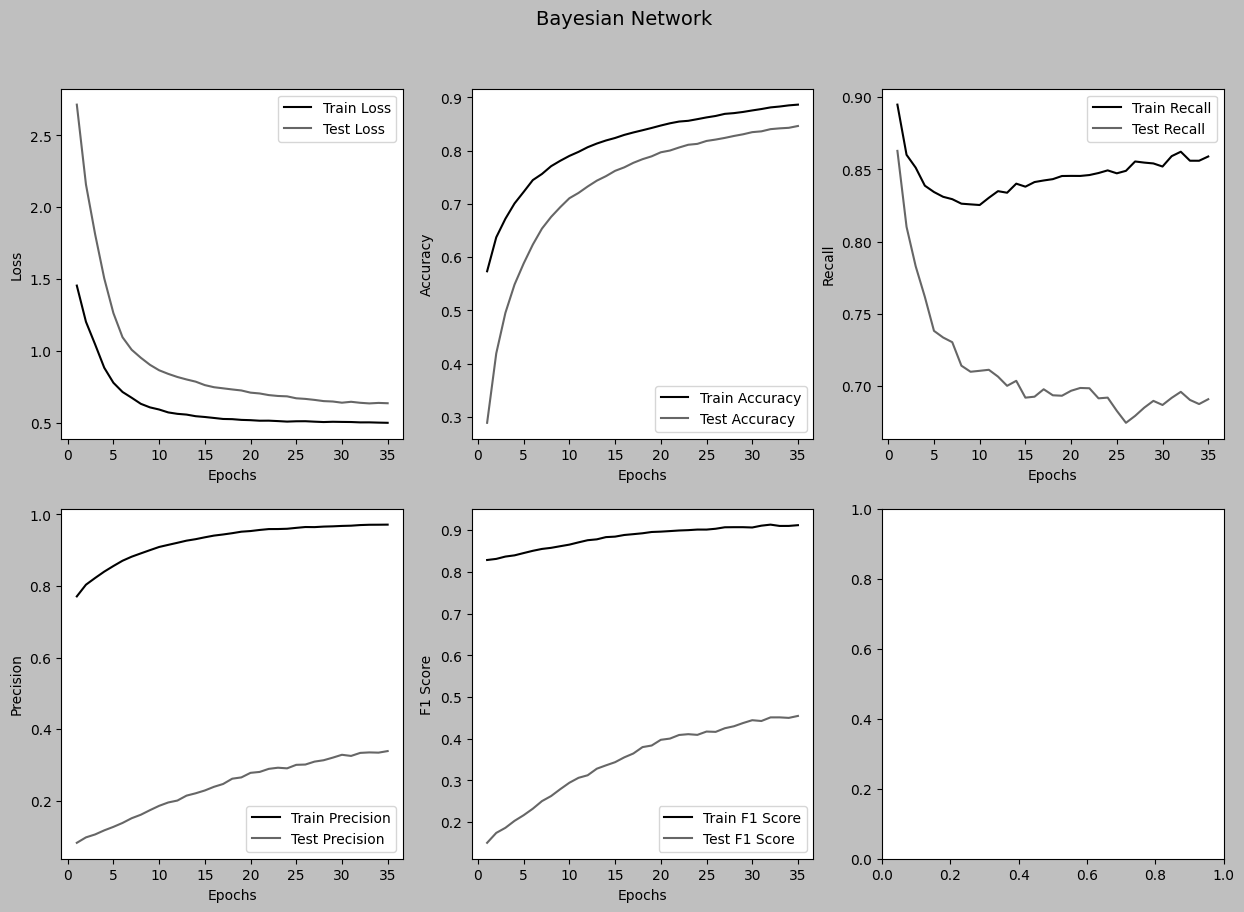

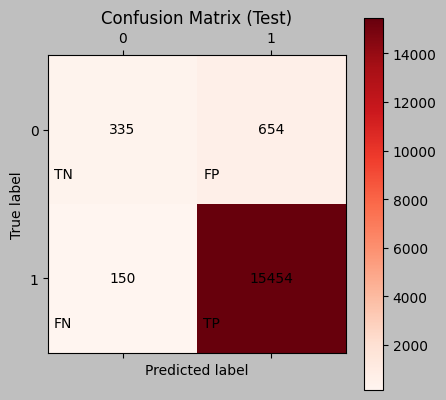

In [86]:
# Bayesian model definition
Bayesian_model = Sequential(
    Linear(187, 200),
    Tanh(),

    Linear(200, 40),
    Tanh(),

    Linear(40, 5),
    Sigmoid(),
)

# Training parameters
epochs = 35
eval_every = 1
batch_size = 1024
learning_rate = 0.001

# Optimizer initialization
optimizer = Adam(Bayesian_model)

# Lists to store metrics during training and testing
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
train_recalls = []
test_recalls = []
train_precisions = []
test_precisions = []
train_f1_scores = []
test_f1_scores = []

# Training loop
for epoch in range(epochs):
    for x, y in DataLoader(X_train, y_train, batch_size=batch_size):
        Bayesian_model.train()

        y_pred = Bayesian_model.forward(x)
        grad = criterion.backward(y_pred, y)
        Bayesian_model.backward(x, grad)

        optimizer.step(lr=learning_rate, beta1=0.9, beta2=0.999)

    if (epoch + 1) % eval_every == 0:
        Bayesian_model.eval()

        y_train_pred = Bayesian_model.forward(X_train)
        y_test_pred = Bayesian_model.forward(X_test)

        loss_train = criterion.forward(y_train_pred, y_train)
        loss_test = criterion.forward(y_test_pred, y_test)
        
        acc_train = accuracy_score(y_train, y_train_pred)
        acc_test = accuracy_score(y_test, y_test_pred)
        
        recall_train = recall_score(y_train, y_train_pred)
        recall_test = recall_score(y_test, y_test_pred)
        
        precision_train = precision_score(y_train, y_train_pred)
        precision_test = precision_score(y_test, y_test_pred)
        
        f1_score_train = f1_score(y_train, y_train_pred)
        f1_score_test = f1_score(y_test, y_test_pred)
        confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
        confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
        
        # Append metrics to lists
        train_losses.append(loss_train)
        test_losses.append(loss_test)
        train_accuracies.append(acc_train)
        test_accuracies.append(acc_test)
        train_recalls.append(recall_train)
        test_recalls.append(recall_test)
        train_precisions.append(precision_train)
        test_precisions.append(precision_test)
        train_f1_scores.append(f1_score_train)
        test_f1_scores.append(f1_score_test)

        if (epoch + 1) % 5 == 0:
            print(f'Epoch: {epoch + 1}/{epochs}')
            print(f'Train Loss: {loss_train} Train Accuracy: {acc_train} Train Recall: {recall_train} Train Precision: {precision_train}')
            print(f'Test Loss: {loss_test} Test Accuracy: {acc_test} Test Recall: {recall_test} Test Precision: {precision_test}\n')

# Calculate confusion matrix




# Plotting
plt.figure(figsize=(15, 10))
plt.figtext(0.5, 0.95, 'Bayesian Network', ha='center', va='center', fontsize=14)

plt.subplot(2, 3, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(range(1, epochs+1), train_recalls, label='Train Recall')
plt.plot(range(1, epochs+1), test_recalls, label='Test Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(range(1, epochs+1), train_precisions, label='Train Precision')
plt.plot(range(1, epochs+1), test_precisions, label='Test Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(range(1, epochs+1), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, epochs+1), test_f1_scores, label='Test F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()


plt.subplot(2, 3, 6)
plt.matshow(confusion_matrix_test, cmap='Reds')
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.colorbar()

# Annotate the confusion matrix with counts or percentages
for i in range(confusion_matrix_test.shape[0]):
    for j in range(confusion_matrix_test.shape[1]):
        plt.text(j, i, str(confusion_matrix_test[i, j]), ha='center', va='center', color='black')
        
# Annotate the confusion matrix with TP, TN, FP, FN labels
for i in range(confusion_matrix_test.shape[0]):
    for j in range(confusion_matrix_test.shape[1]):
        if i == 0 and j == 0:  # TN
            plt.text(j - 0.4, i + 0.3, 'TN', ha='center', va='center', color='black')
        elif i == 1 and j == 1:  # TP
            plt.text(j - 0.4, i + 0.3, 'TP', ha='center', va='center', color='black')
        elif i == 0:  # FP
            plt.text(j - 0.4, i + 0.3, 'FP', ha='center', va='center', color='black')
        else:  # FN
            plt.text(j - 0.4, i + 0.3, 'FN', ha='center', va='center', color='black')


plt.show()